
# Predicting the Red Wine quality score 

**Introduction**

A 2022 study conducted by John Dunham and Associates found that the wine industry accounts for $276.07 billion economic output in America. While wine is a cornerstone of the US economy, few individuals are actually experts in the subject, with only 269 Master Sommeliers in the world. There is a clear disconnect between the economic impact of wine, and the number of individuals trained to assess a wine's quality, leaving room for restaraunts, liquor stores, and wineries to over (or under) price wines for consumers. During our project, we will be using predictors that could be found by contacting wine producers to see if we can predict the quality [0-10] of a red wine using regression.

The dataset chosen was collected by Cortez et al.(2009) for their paper, "Modeling wine preferences by data mining from physicochemical properties", in which they modelled wine preference on a scale of 0 [bad] to 10 [excellent]. Cortez et al. used 12 types of physicochemical properties, whereas we we will use 7 in our prediction model.  


**Preliminary Exploratory Data Analysis:**



In [1]:
#loading necessary packages
set.seed(4789)
library(repr)
library(tidyverse)
library(tidymodels)
install.packages("corrplot")
library(corrplot)
library(GGally)
library(cowplot)
library(broom)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_data <- read_delim(url, skip = 1, delim = ";",
                       col_names = c("fixed_acidity",
                                     "volatile_acidity",
                                     "citric_acid",
                                     "residual_sugar",
                                     "chlorides",
                                     "free_sulfur_dioxide",
                                     "total_sulfur_dioxide",
                                     "density",
                                     "pH",
                                     "sulphates",
                                     "alcohol",
                                     "quality")) |>
              mutate(across("fixed_acidity":"quality", as.numeric))
wine_data

#reading wine_data

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed_acidity, volatile_acidity, citric_acid, residual_sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.3,0.510,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11.0,6
5.9,0.645,0.12,2.0,0.075,32,44,0.99547,3.57,0.71,10.2,5
6.0,0.310,0.47,3.6,0.067,18,42,0.99549,3.39,0.66,11.0,6


Commentary of range of data (scaling benefits)

In [3]:
#splitting wine data into training/testing
wine_split <- initial_split(wine_data, prop = 0.75, strata = quality)
wine_training <- training(wine_split)
wine_testing <- testing(wine_split)



In [4]:
#summary of wine data

wine_max <- wine_training |>
            summarize(across("fixed_acidity":"quality", max, na.rm = TRUE))

wine_min <- wine_training |>
            summarize(across("fixed_acidity":"quality", min, na.rm = TRUE))

wine_mean <- wine_training |>
             summarize(across("fixed_acidity":"quality", mean, na.rm = TRUE))

wine_summary <- bind_rows(wine_min, wine_mean, wine_max)
wine_summary

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.600000,0.1200000,0.0000000,0.90000,0.01200000,1.00000,6.00000,0.9900700,2.740000,0.3300000,8.40000,3.000000
8.274875,0.5292571,0.2673122,2.50505,0.08690317,16.10601,47.34349,0.9967086,3.316135,0.6554174,10.43147,5.634391
15.900000,1.3300000,1.0000000,15.50000,0.61000000,72.00000,289.00000,1.0032000,4.010000,2.0000000,14.90000,8.000000


The above table is a summary of the training dataset. The first row is the minimum value of each variable, the second row is the mean value of each variable, and the third row is the maximum value of each variable. This lets us know the range of values we should expect to see for each variable when we do our analysis.

,Fixed Acidity,Volatile Acidity,Citric Acid,Residual Sugar,Chlorides,Free Sulfur Dioxide,Total Sulfur Dioxide,Density,pH,Sulphates,Alcohol,Quality
Fixed Acidity,1.00,-0.25,0.66,0.07,0.11,-0.17,-0.11,0.66,-0.68,0.18,-0.09,0.10
Volatile Acidity,-0.25,1.00,-0.55,0.00,0.05,-0.01,0.08,0.04,0.23,-0.25,-0.19,-0.37
Citric Acid,0.66,-0.55,1.00,0.12,0.20,-0.06,0.05,0.35,-0.54,0.29,0.08,0.19
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Sulphates,0.18,-0.25,0.29,-0.03,0.38,0.04,0.04,0.14,-0.19,1.00,0.09,0.24
Alcohol,-0.09,-0.19,0.08,0.05,-0.23,-0.06,-0.21,-0.52,0.22,0.09,1.00,0.47
Quality,0.10,-0.37,0.19,-0.02,-0.15,-0.05,-0.19,-0.20,-0.02,0.24,0.47,1.00


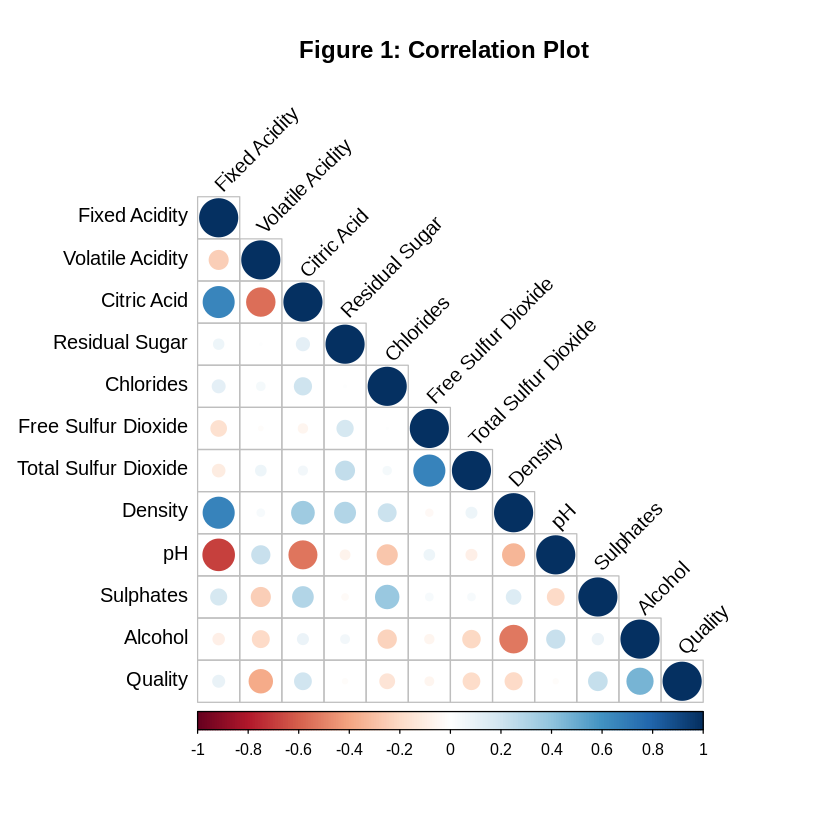

In [5]:
# making a correlation plot
corr <- cor(wine_training)
colnames(corr)<- c("Fixed Acidity", "Volatile Acidity", "Citric Acid", "Residual Sugar", "Chlorides", "Free Sulfur Dioxide", "Total Sulfur Dioxide","Density", "pH", "Sulphates", "Alcohol", "Quality") 
rownames(corr)<- c("Fixed Acidity", "Volatile Acidity", "Citric Acid", "Residual Sugar", "Chlorides", "Free Sulfur Dioxide", "Total Sulfur Dioxide","Density", "pH", "Sulphates", "Alcohol", "Quality") 
round(corr, 2)
corrplot(corr, type = "lower", 
         tl.col = "black", tl.srt = 45) 
title(main = list("Figure 1: Correlation Plot", font= 15)) 

**K-nn Regression**

In [7]:
# MAKING A K-NN REGRESSION MODEL.
wine_spec_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 
# MAKING THE K-NN RECIPE.
wine_recipe_knn <- recipe(quality ~ alcohol+ total_sulfur_dioxide + 
                          volatile_acidity + citric_acid + density + sulphates , data = wine_training) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())
# PERFORMING CROSS-VALIDATION.
wine_vfold <- vfold_cv(wine_training, v = 10, strata = quality)
gridvals <- tibble(neighbors = seq(1, 150)) 
wine_results_knn <- workflow() |> 
                    add_recipe(wine_recipe_knn) |> 
                    add_model(wine_spec_knn) |>
                    tune_grid(resamples = wine_vfold, grid = gridvals) |> 
                    collect_metrics() |>
                    filter(.metric == "rmse")


In [8]:
wine_results_knn

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,0.7864897,10,0.014339136,Preprocessor1_Model001
2,rmse,standard,0.7053903,10,0.010732739,Preprocessor1_Model002
3,rmse,standard,0.6823865,10,0.008287051,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
148,rmse,standard,0.6612931,10,0.01177890,Preprocessor1_Model148
149,rmse,standard,0.6614031,10,0.01181208,Preprocessor1_Model149
150,rmse,standard,0.6614471,10,0.01183242,Preprocessor1_Model150


In [9]:
# GETTING K FOR WHICH THE RMSPE IS LOWEST.
wine_knn_min <- wine_results_knn |> 
                arrange(mean) |> 
                head(1) |>
                pull(neighbors)
wine_knn_min

[1] 15

In [171]:
# PLOTTING RMSPE VS NEIGHBOURS TO VISUALISE WHERE RMSPE IS LOWEST.
options(repr.plot.width = 30, repr.plot.height = 20)
wine_k_plot <- wine_results_knn |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point(size = 3) +
    geom_line(size = 2) +
    geom_vline(xintercept = 15, colour = "red", size = 2) +
    labs(x = "Neighbours (K)",
         y = "RMSPE",
         title = "RMSPE vs Neighbours ", captions = "Figure. 2") +
    theme(text = element_text(size = 40),
          plot.caption = element_text(size = 60, hjust = 0)) + 
        scale_x_continuous(breaks = c(0,), lim= c(0,150))        

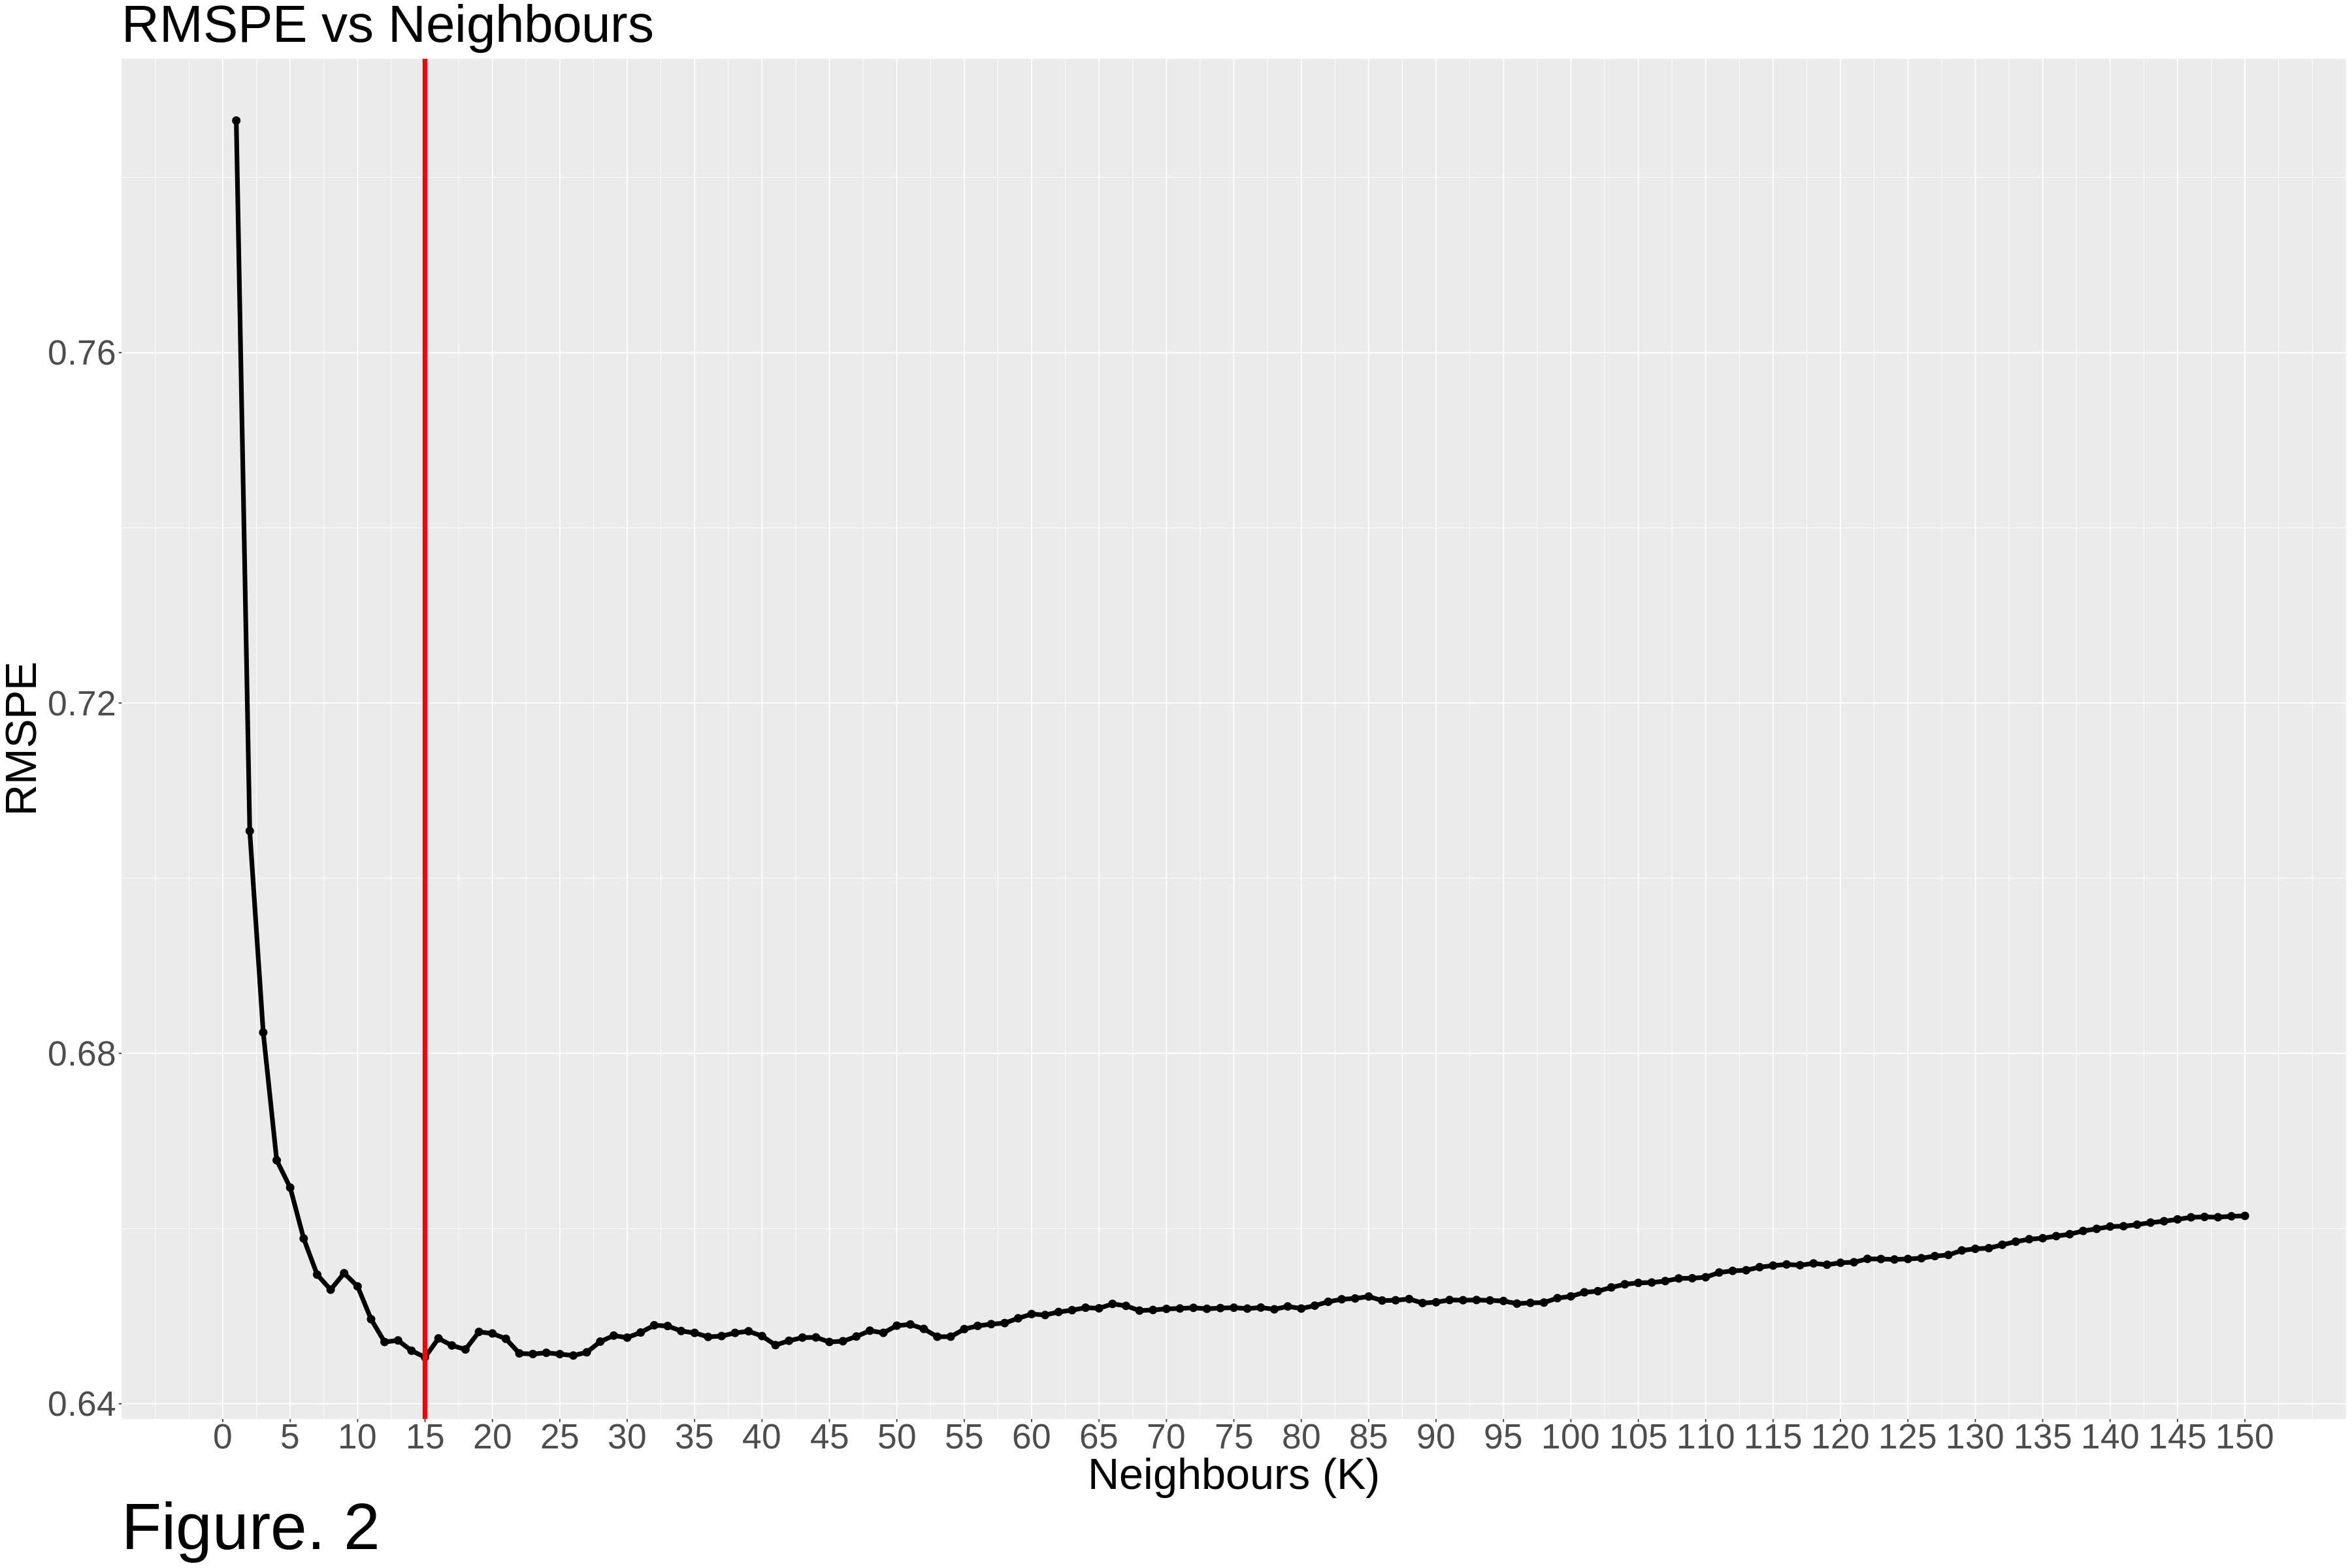

In [172]:
wine_k_plot

In [12]:
# MAKING THE K-NN MODEL WITH IDEAL NUMBER OF NEIGHBOURS.
wine_best_spec_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = wine_knn_min) |>
          set_engine("kknn") |>
          set_mode("regression")
# FITTING THE MODEL WITH THE TRAINING DATA.
wine_best_fit_knn <- workflow() |>
           add_recipe(wine_recipe_knn) |>
           add_model(wine_best_spec_knn) |>
           fit(data = wine_training)
# PREDICTING THE MODEL ON TESTING DATA.
wine_summary_knn <- wine_best_fit_knn |>
           predict(wine_testing) |>
           bind_cols(wine_testing) |>
           metrics(truth = quality, estimate = .pred)

wine_summary_knn

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.6671486
rsq,standard,0.3735247
mae,standard,0.5160432


In [13]:
# GETTING THE RMSE FROM K-NN REGRESSION.
wine_knn_rmse <- wine_summary_knn |> 
                    filter(.metric == 'rmse') |> 
                    pull()
wine_knn_rmse

[1] 0.6671486

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


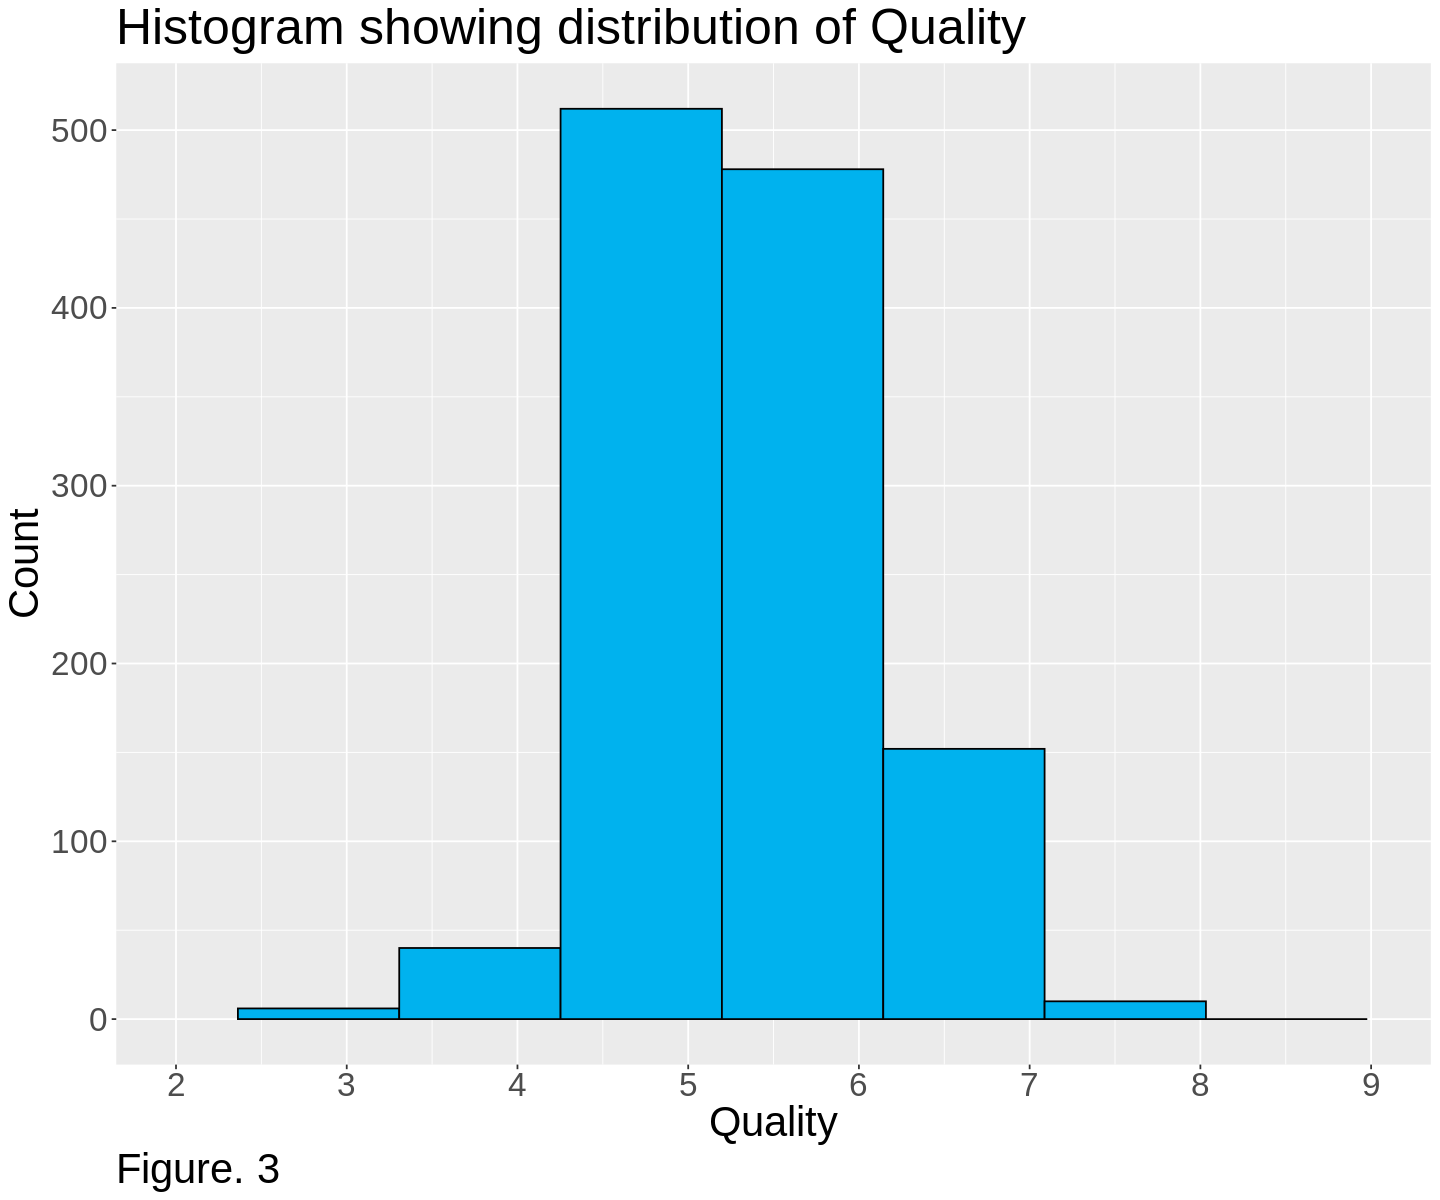

In [143]:
options(repr.plot.width = 12, repr.plot.height = 10)
 wine_training |> 
                ggplot(aes(x = quality))+ geom_histogram(binwidth = 0.945, fill = "deepskyblue2", col = "black") + theme(text = element_text(size = 25),
          plot.caption = element_text(size = 25, hjust = 0)) + labs(x = "Quality", y= "Count", title = "Histogram showing distribution of Quality", caption = "Figure. 3") +
            scale_x_continuous(breaks = c(2,3,4,5,6,7,8,9), lim = c(2,9))


**Linear Regression**

In [14]:
lm_spec <- linear_reg() |>
           set_engine("lm") |>
           set_mode("regression")

lm_recipe <- recipe(quality ~ alcohol + total_sulfur_dioxide + 
                    volatile_acidity + citric_acid + density + sulphates, data = wine_training)

lm_fit <- workflow() |>
       add_recipe(lm_recipe) |>
       add_model(lm_spec) |>
       fit(wine_training)

lm_fit

lm_rmspe <- lm_fit |>
         predict(wine_testing) |>
         bind_cols(wine_testing) |>
         metrics(truth = quality, estimate = .pred) |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

lm_rmspe

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
         (Intercept)               alcohol  total_sulfur_dioxide  
            -5.28804               0.29671              -0.00216  
    volatile_acidity           citric_acid               density  
            -1.23185              -0.15553               8.18693  
           sulphates  
             0.70654  


[1] 0.6632904

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



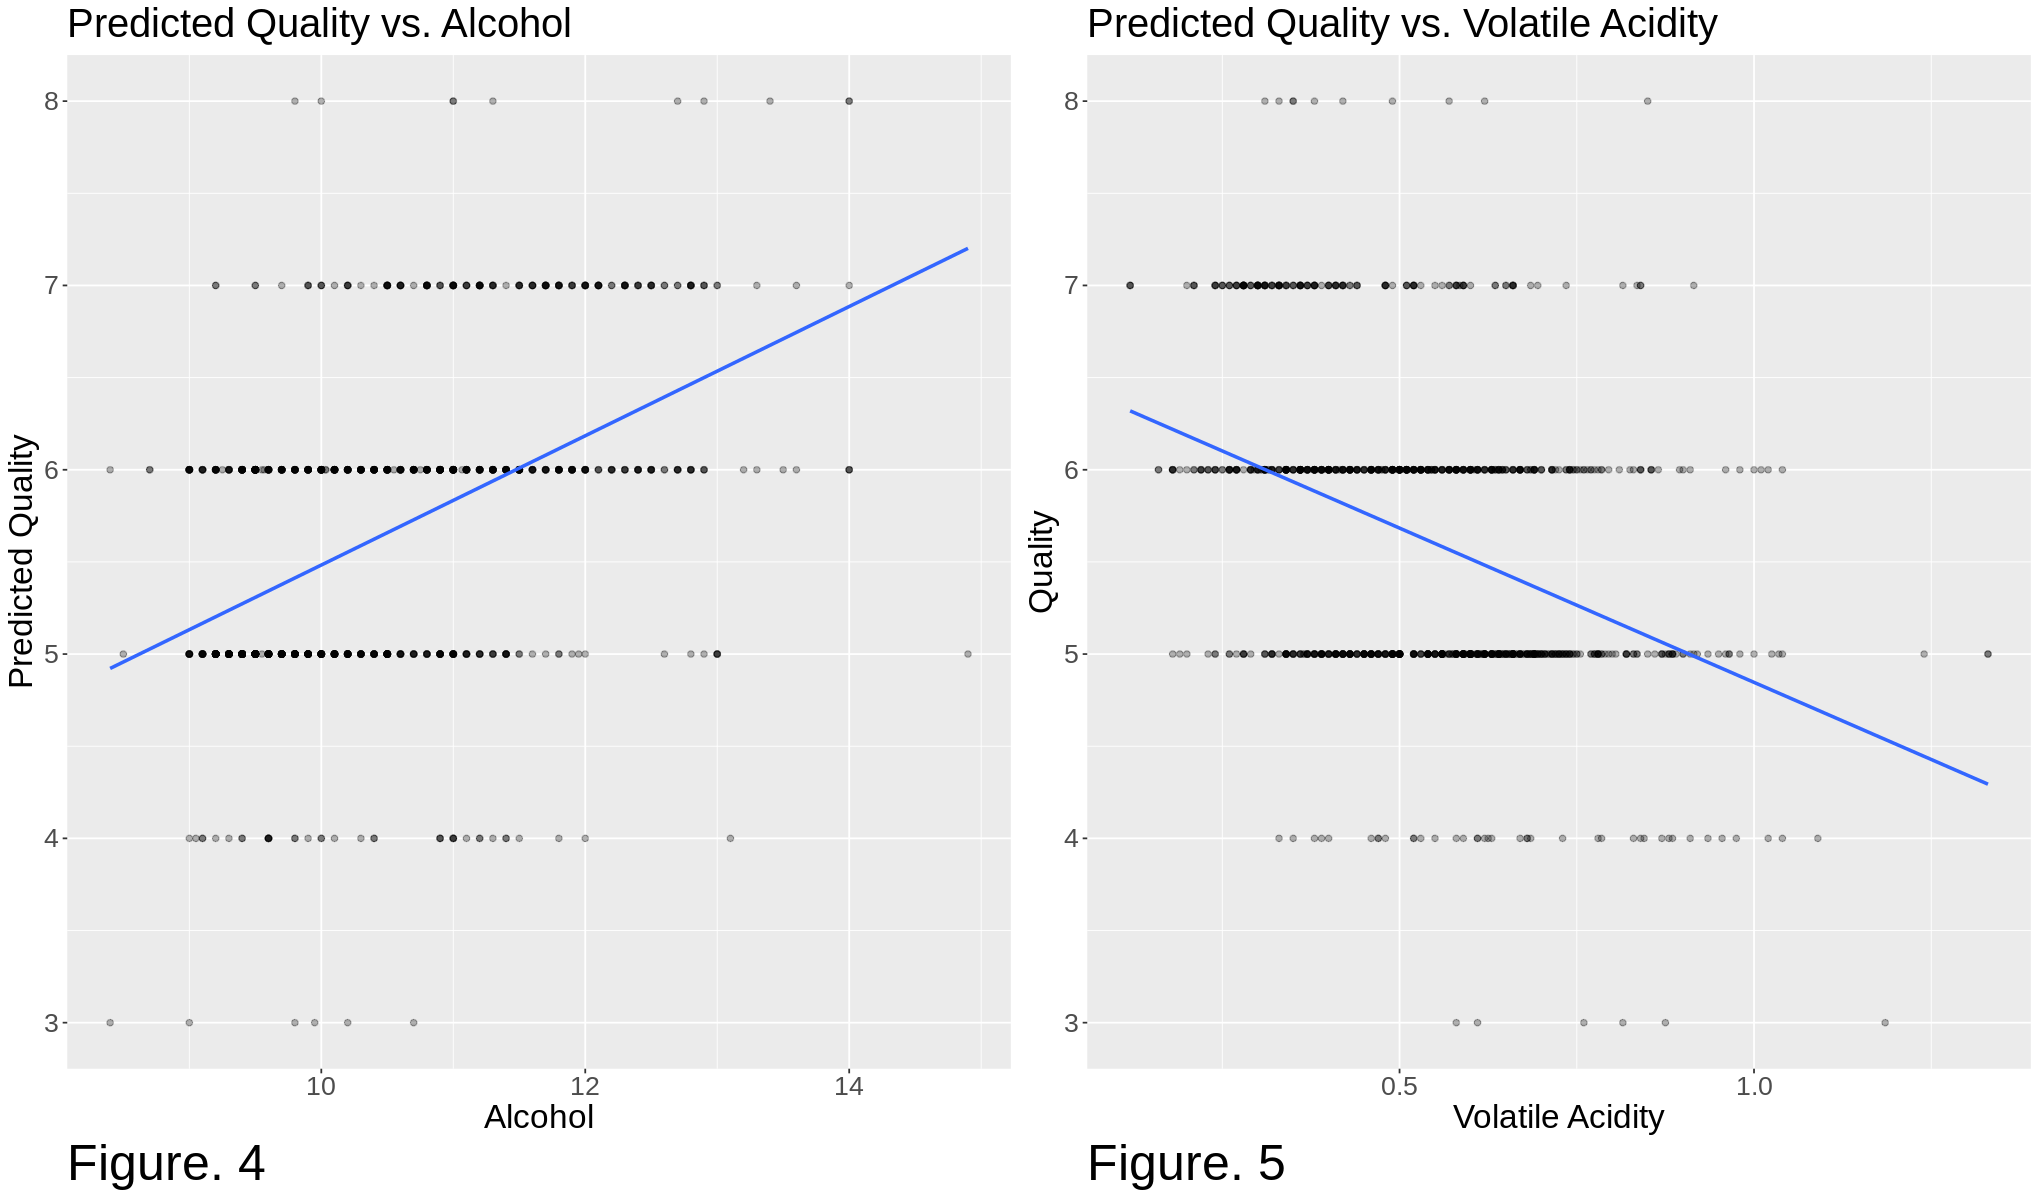

In [170]:
# PLOTTING PREDICTED QUALITY AGAINST TWO PREDICTORS THAT CONTRIBUTE THE MOST TO THE MODEL.
options(repr.plot.width = 17, repr.plot.height = 10)
lm_quality_vs_alcohol<- ggplot(wine_training, aes(x = alcohol, y = quality)) +
  geom_point(alpha = 0.3) + labs(x ="Alcohol", y= "Predicted Quality", captions= "Figure. 4", title = "Predicted Quality vs. Alcohol")+
  geom_smooth(method = "lm", se = FALSE) +   theme(text = element_text(size = 20),
          plot.caption = element_text(size = 30, hjust = 0))

lm_quality_vs_volatile_acidity<- ggplot(wine_training, aes(x = volatile_acidity, y = quality)) +
  geom_point(alpha = 0.3) +
  labs(x ="Volatile Acidity", y= "Quality", captions= "Figure. 5", title = "Predicted Quality vs. Volatile Acidity")+
  geom_smooth(method = "lm", se = FALSE) +   theme(text = element_text(size = 20),
          plot.caption = element_text(size = 30, hjust = 0))

plot_grid(lm_quality_vs_alcohol, lm_quality_vs_volatile_acidity, ncol = 2)

New names:
• `.fitted` -> `.fitted...1`
• `.fitted` -> `.fitted...9`


quality,alcohol,total_sulfur_dioxide,volatile_acidity,citric_acid,density,sulphates,.fitted,.fitted_rounded,.resid,.hat,.sigma,.cooksd,.std.resid
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,9.8,54,0.76,0.04,0.9970,0.65,5.089126,5,-0.08912615,0.008610935,0.6665653,2.243224e-05,-0.13445664
6,9.8,60,0.28,0.56,0.9980,0.58,5.706694,6,0.29330582,0.014616847,0.6664139,4.174314e-04,0.44383065
5,9.4,34,0.70,0.00,0.9978,0.56,5.024634,5,-0.02463448,0.011118792,0.6665794,2.224111e-06,-0.03721092
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6,11.9,26,0.350,0.33,0.99470,0.60,6.321229,6,-0.3212293,0.010669852,0.6663815,0.0003625823,-0.4851139
6,9.5,38,0.620,0.08,0.99651,0.82,5.327213,5,0.6727867,0.011237750,0.6657063,0.0016770682,1.0163204
5,10.2,44,0.645,0.12,0.99547,0.71,5.421489,5,-0.4214892,0.006346753,0.6662393,0.0003680910,-0.6351382


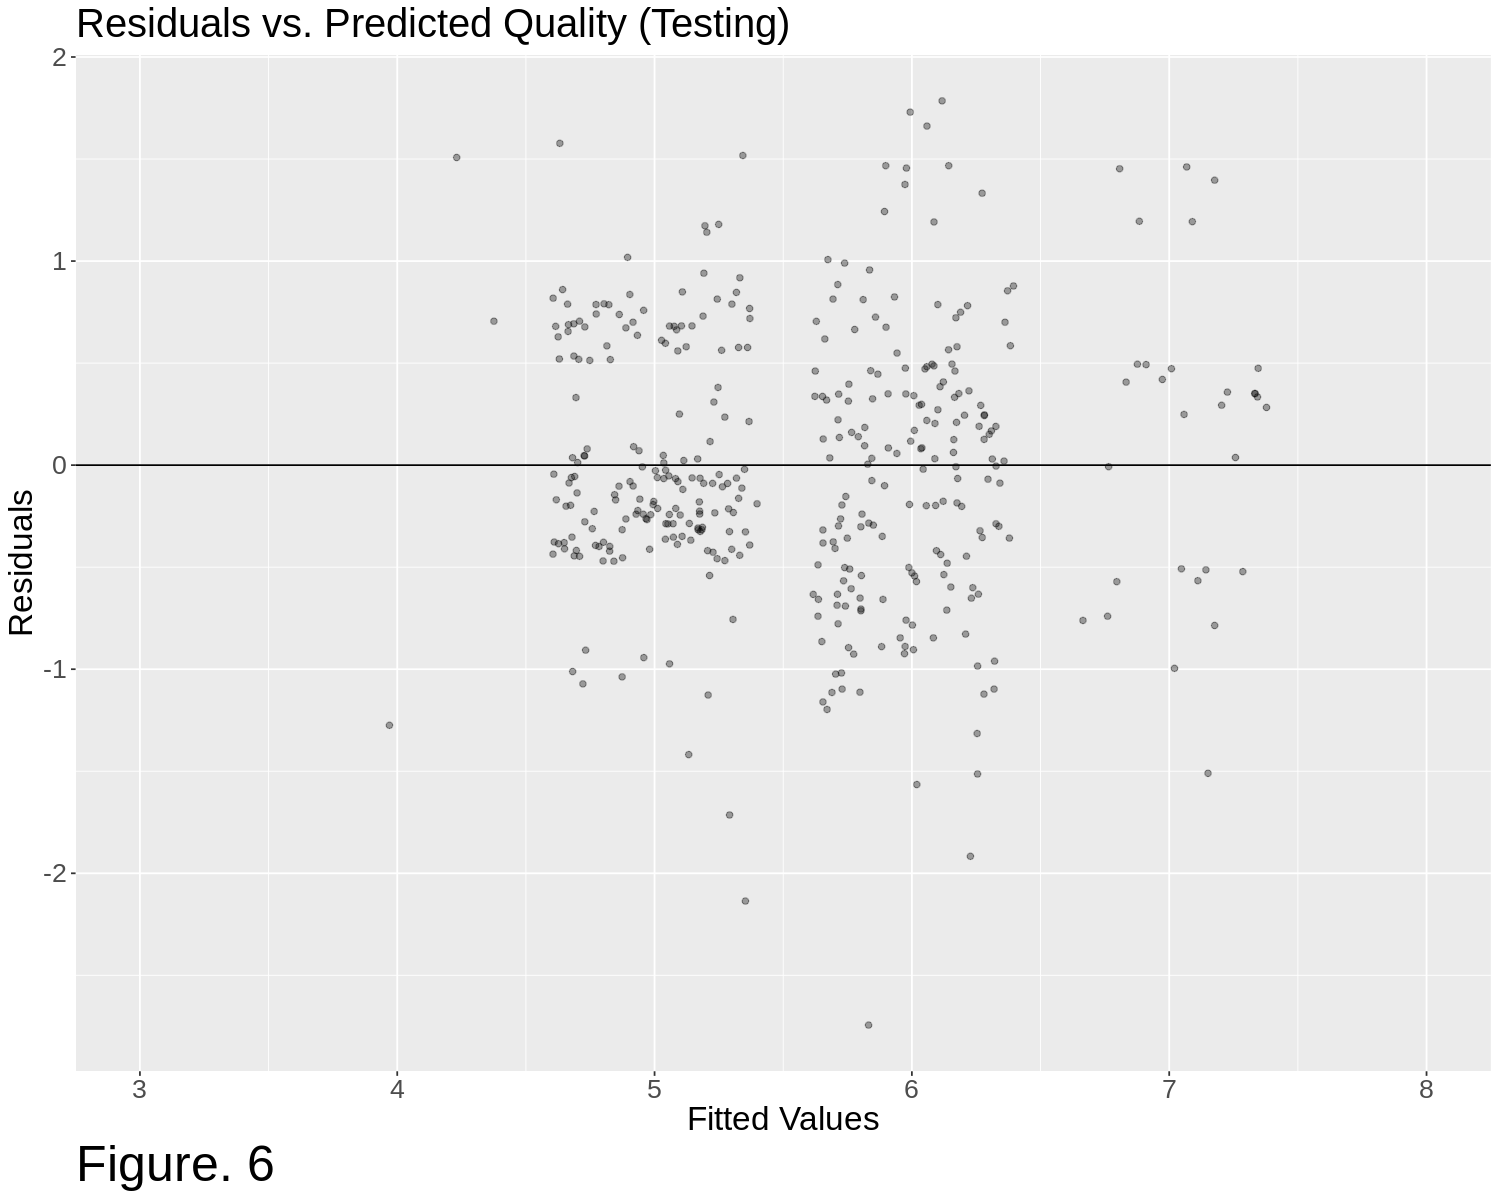

In [153]:
# PLOTTING A RESIDUAL PLOT TO VISUALISE RMSE OF LINEAR REGRESSION MODEL.
options(repr.plot.width = 12.5, repr.plot.height = 10)
lm_model<- lm(quality ~ alcohol + total_sulfur_dioxide + 
                    volatile_acidity + citric_acid + density + sulphates, data = wine_testing)
lm_residuals_augment<- augment(lm_model)
lm_residuals_augment_rounded <- lm_residuals_augment |>
                                    round() |>
                                    select(.fitted) |>
                                    bind_cols(lm_residuals_augment) |>
                                    rename(.fitted_rounded = .fitted...1, .fitted = .fitted...9) |>
                                    select(quality,alcohol,total_sulfur_dioxide,volatile_acidity,citric_acid,density,sulphates,.fitted,
                                          .fitted_rounded, .resid,.hat, .sigma, .cooksd, .std.resid)
lm_residuals_augment_rounded
lm_residual_plot_testing<-ggplot(lm_residuals_augment_rounded, aes(x = .fitted_rounded, y = .resid )) + 
                    geom_point(alpha = 0.35,  position = "jitter") +geom_hline(yintercept= 0)+
                labs(x = "Fitted Values", y= "Residuals", title = "Residuals vs. Predicted Quality (Testing)", caption = "Figure. 6")+
                    theme(text = element_text(size = 20),
          plot.caption = element_text(size = 30, hjust = 0))+ 
                scale_x_continuous(breaks = c(2,3,4,5,6,7,8), lim = c(3,8))

lm_residual_plot_testing 

**Methods**

Building a good model requires a careful selection of relevant predictors. Our dataset contains 11 variables of which many are redundant. We will use both our insights and a correlation matrix to determine which ones to use.

Firstly, alcohol will be used, since it is known to impact individuals' perception of wine flavour, thus influencing perceived quality (Caballero & Segura, 2017). Secondly, total sulphur dioxide will be used, total sulphur dioxide acts as an antioxidant with probable impacts on quality (Araptisas et al., 2018). The correlation matrix also suggests that sulphates, volatile_acidity, citric_acid and density are significant. The ID is distributed randomly so it does not have an impact.

Even though our prediction set consists of 11 integer values, we will be using regression for prediction. The quality values are ordered and the dataset is too unbalanced, with most of the values centred around the mean value, to use a classifier. We believe using multiple linear regression with 6 regressors should provide us with the best results. Rounding our predicted number to the nearest integer will give us a quality score that could be easily checked by the confusion matrix. We will then use the values to calculate the accuracy score.

**Expected Outcomes and Significance**

We expect to be able to predict the quality of a particular sample, on a scale of 0(bad) to 10(excellent).

This analysis will be helpful to both winemakers and businesses. Winemakers could use our model to better understand what makes a high-quality wine and what they can use to engineer a more enjoyable wine without wasteful trial and error. Businesses like hotels and restaurants could also predict the quality of wine if it is unknown to purchase only the wines that have good quality to maximize their profits.

If our data analysis is successful, we can look into other factors that determine the quality of a particular wine like its origin, growing practices(grapes), winemaking practices, the temperature at which it's fermented, age, etc. We can also conduct a data analysis linking price to the quality of the wine.

**Data Sources:**

https://archive.ics.uci.edu/ml/datasets/wine+quality

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

2022 economic impact study of the American wine industry methodology. WineAmerica. (2022, September 21). Retrieved October 28, 2022, from https://wineamerica.org/economic-impact-study/2022-american-wine-industry-methodology/ 

Members archive. Court of Master Sommeliers Europe. (n.d.). Retrieved October 28, 2022, from https://www.courtofmastersommeliers.org/members/ 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5328826/#:~:text=First%2C%20for%20the%20wine%20industry,sluggish%20or%20even%20stuck%20fermentations.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5770432/

Reminders:
- commentary on our choice of predictors
- for our correlation plot, describe what the plot shows! 
- add plot titles and figures

Code: 
- add visualization or summary table to show that our data is unbalanced (bar plot will suffice!) 
- incorporate predictions into a visualization in final report (graph w/ colours?)